In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=250, noise=0.2, random_state=42)

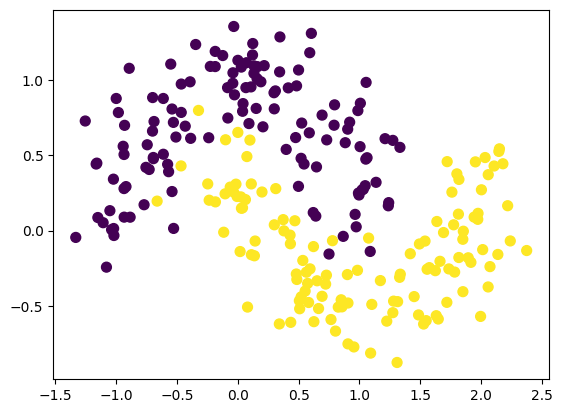

In [3]:
plt.scatter(X[:,0], X[:,1], c=y, s=50)
plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
class weight_init_non_zero(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Sigmoid(),
            nn.Linear(in_features=5, out_features=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.linear_stack(x)

model = weight_init_non_zero().to(device)

In [6]:
model

weight_init_non_zero(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [7]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[-0.1120,  0.5501],
                      [ 0.2746,  0.3356],
                      [-0.0756, -0.0294],
                      [ 0.1551, -0.6768],
                      [-0.1720, -0.3653]])),
             ('linear_stack.0.bias',
              tensor([-0.1928, -0.6674, -0.0151, -0.7060, -0.0242])),
             ('linear_stack.2.weight',
              tensor([[ 0.1429, -0.1474,  0.4271, -0.4258, -0.1932]])),
             ('linear_stack.2.bias', tensor([0.0267]))])

In [8]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

21

In [10]:
# Given weights and biases
weights = [
    torch.tensor([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]], dtype=torch.float32),  # fc1 weight
    torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5], dtype=torch.float32),                 # fc1 bias
    torch.tensor([[0.5], [0.5]], dtype=torch.float32),           # fc2 weight
    torch.tensor([0.5], dtype=torch.float32)                      # fc2 bias
]

In [11]:
weights

[tensor([[0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]]),
 tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000]),
 tensor([[0.5000],
         [0.5000]]),
 tensor([0.5000])]

In [12]:
model.linear_stack[0].weight

Parameter containing:
tensor([[-0.1120,  0.5501],
        [ 0.2746,  0.3356],
        [-0.0756, -0.0294],
        [ 0.1551, -0.6768],
        [-0.1720, -0.3653]], requires_grad=True)

In [13]:
weights[0]

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]])

In [14]:
model.linear_stack[2].weight

Parameter containing:
tensor([[ 0.1429, -0.1474,  0.4271, -0.4258, -0.1932]], requires_grad=True)

In [15]:
weights[1]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000])

In [16]:
weights[3]

tensor([0.5000])

In [17]:
model.linear_stack[2].bias

Parameter containing:
tensor([0.0267], requires_grad=True)

In [18]:
with torch.no_grad():
    model.linear_stack[0].weight.copy_(weights[0])  
    model.linear_stack[0].bias.copy_(weights[1])
    model.linear_stack[2].weight.copy_(weights[1])
    model.linear_stack[2].bias.copy_(weights[3])

# Verify the assigned weights
print("Layer 1 weights:", model.linear_stack[0].weight)
print("Layer 1 bias:", model.linear_stack[0].bias)
print("Layer 2 weights:", model.linear_stack[2].weight)
print("Layer 2 bias:", model.linear_stack[2].bias)

Layer 1 weights: Parameter containing:
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]], requires_grad=True)
Layer 1 bias: Parameter containing:
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000], requires_grad=True)
Layer 2 weights: Parameter containing:
tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000]], requires_grad=True)
Layer 2 bias: Parameter containing:
tensor([0.5000], requires_grad=True)


In [19]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[0.5000, 0.5000],
                      [0.5000, 0.5000],
                      [0.5000, 0.5000],
                      [0.5000, 0.5000],
                      [0.5000, 0.5000]])),
             ('linear_stack.0.bias',
              tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000])),
             ('linear_stack.2.weight',
              tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])),
             ('linear_stack.2.bias', tensor([0.5000]))])

In [20]:
# loss_fc and optimizer
loss_fc = nn.BCELoss() 

optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.001)

In [21]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [22]:
# building a training and evaluation loop

epochs = 100

for epoch in range(epochs):

  model.train()

  # forward pass
  y_logits = model(X).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (perform gradient descent)
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model(X).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y)


# lets print out what is happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")

Epoch: 0 | Loss: 1.21310
Epoch: 10 | Loss: 1.19149
Epoch: 20 | Loss: 1.17030
Epoch: 30 | Loss: 1.14957
Epoch: 40 | Loss: 1.12934
Epoch: 50 | Loss: 1.10965
Epoch: 60 | Loss: 1.09049
Epoch: 70 | Loss: 1.07187
Epoch: 80 | Loss: 1.05381
Epoch: 90 | Loss: 1.03629


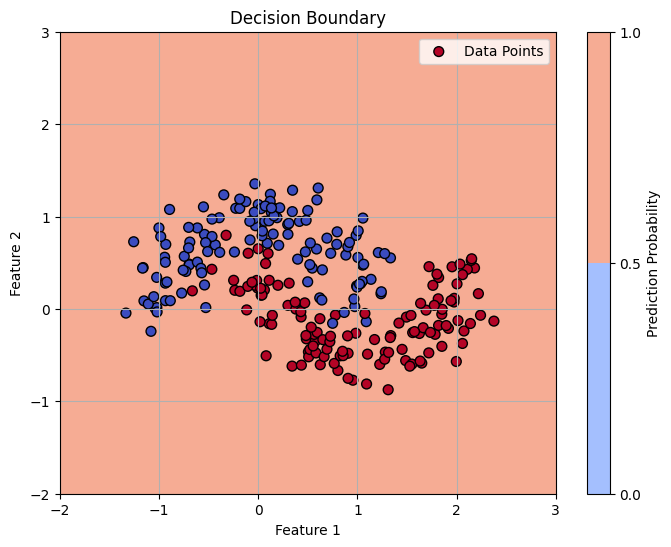

In [23]:
# 1. Generate a grid of points
x1_range = np.linspace(-2.0, 3.0, 200)
x2_range = np.linspace(-2.0, 3.0, 200)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# 2. Predict probabilities for the grid points
with torch.no_grad():
    grid_preds = model(grid_tensor).numpy()

# 3. Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(x1_grid, x2_grid, grid_preds.reshape(x1_grid.shape), levels=[0, 0.5, 1], alpha=0.8, cmap='coolwarm')
plt.colorbar(label='Prediction Probability')

# 4. Overlay the data points
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolor='k', cmap='coolwarm', s=50, label='Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.legend()
plt.grid()
plt.show()

In [24]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[0.5987, 0.4034],
                      [0.5987, 0.4034],
                      [0.5987, 0.4034],
                      [0.5987, 0.4034],
                      [0.5987, 0.4034]])),
             ('linear_stack.0.bias',
              tensor([0.4049, 0.4049, 0.4049, 0.4049, 0.4049])),
             ('linear_stack.2.weight',
              tensor([[0.4031, 0.4031, 0.4031, 0.4031, 0.4031]])),
             ('linear_stack.2.bias', tensor([0.4021]))])